In [1]:
# importing the libraries

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score,confusion_matrix
from sklearn.metrics import roc_curve,accuracy_score, f1_score
import matplotlib.pyplot as plt


In [2]:
# Load the data

train_ds = pd.read_csv('Train_data.csv')
train_ds.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [3]:
train_ds.describe()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,7160.000000,7160.000000,7160.000000,7054.000000,7160.000000,6652.000000,7160.000000
mean,2013.669553,0.909758,0.305447,1883.727530,2.186034,1964.456404,0.228212
std,1.383769,0.239756,0.460629,2278.157745,0.940632,36.002014,0.419709
min,2012.000000,0.000000,0.000000,1.000000,1.000000,1545.000000,0.000000
25%,2012.000000,0.997268,0.000000,528.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,1083.000000,2.000000,1970.000000,0.000000
75%,2015.000000,1.000000,1.000000,2289.750000,3.000000,1980.000000,0.000000
max,2016.000000,1.000000,1.000000,20940.000000,4.000000,2016.000000,1.000000


In [4]:
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.3+ KB


In [5]:
# Check missing values
missing = train_ds.isnull().sum()
print("Missing Values:\n", missing[missing > 0])


Missing Values:
 Garden                  7
Building Dimension    106
Date_of_Occupancy     508
Geo_Code              102
dtype: int64


1. Data Cleaning & Preprocessing

Based on the datasets, several columns require specific attention such as 
 * NumberOfWindows which contains '.' values that represents missing data.
 * Building Dimension, Date_of_Occupancy & Geo_Code contain null values
 * Categorial Variables that need encoding (Building_Painted, Building_Fenced, Garden and Settlement )

In [ ]:
# Handling missing values
# Cleaning NumberOfWindows by replacing the '.' string with nan

train_ds['NumberOfWindows'] = train_ds['NumberOfWindows'].replace('.',np.nan)

In [7]:
#convert to float first, then handle as numeric
train_ds['NumberOfWindows'] = pd.to_numeric(train_ds['NumberOfWindows'],errors='coerce')

#impute numerical missing values
num_imputer =SimpleImputer(strategy='median')
train_ds['Building Dimension'] =num_imputer.fit_transform(train_ds[['Building Dimension']])
train_ds['Date_of_Occupancy'] =num_imputer.fit_transform(train_ds[['Date_of_Occupancy']])
train_ds['NumberOfWindows'] =num_imputer.fit_transform(train_ds[['NumberOfWindows']])

#impute categorical missing values (geo_code and Garden)
train_ds['Geo_Code'] =train_ds['Geo_Code'].fillna(train_ds['Geo_Code'].mode()[0])
train_ds['Garden'] = train_ds['Garden'].fillna(train_ds['Garden'].mode()[0])

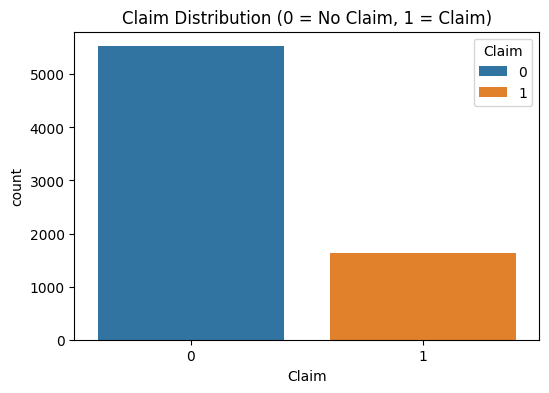

In [ ]:
# --- EDA ---
# Plot 1: Target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Claim', data=train_ds, hue='Claim')
plt.title('Claim Distribution (0 = No Claim, 1 = Claim)')
plt.savefig('Target_distribution.png')

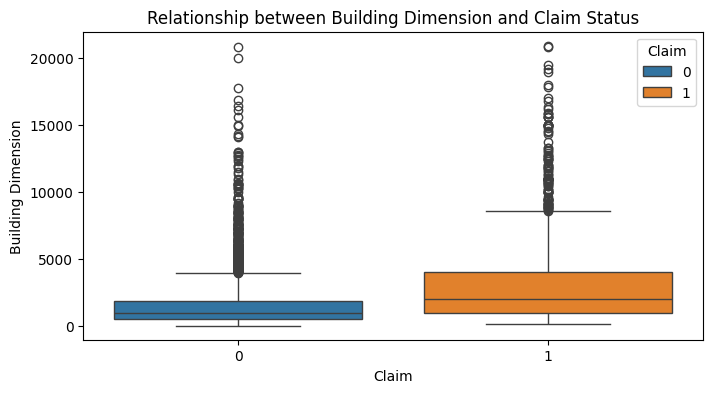

In [ ]:
# Plot 2: Building Dimension vs Claim
plt.figure(figsize=(8, 4))
sns.boxplot(x='Claim', y='Building Dimension', data=train_ds, hue= 'Claim')
plt.title('Relationship between Building Dimension and Claim Status')
plt.savefig('Dimension_vs_claim.png')

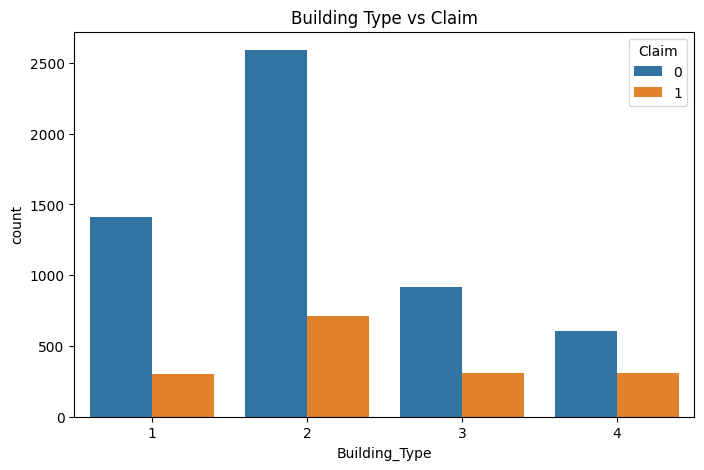

In [10]:
# Plot 3: Building Type vs Claim
plt.figure(figsize=(8, 5))
sns.countplot(x='Building_Type', hue='Claim', data=train_ds)
plt.title('Building Type vs Claim')
plt.savefig('Building_type_vs_claim.png')



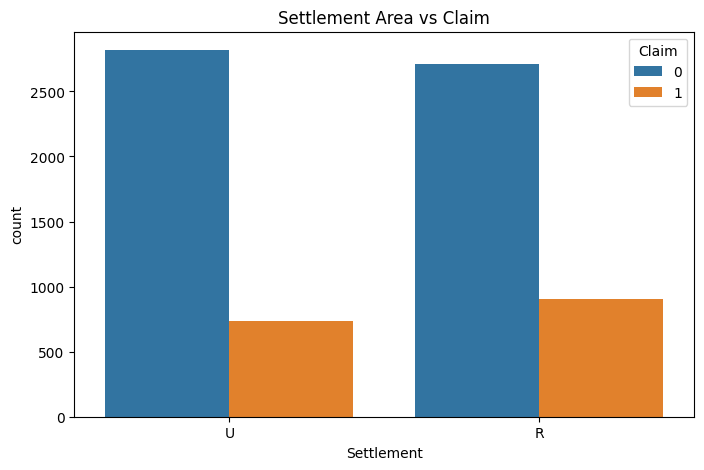

In [11]:
#Plot 4: Settlement vs Claim
plt.figure(figsize=(8, 5))
sns.countplot(x='Settlement', hue='Claim', data=train_ds)
plt.title('Settlement Area vs Claim')
plt.savefig('Settlement_vs_claim.png')

In [12]:
# --- 2. Feature Engineering ---

# Calculate Building Age at the time of observation
train_ds['Building_Age'] = train_ds['YearOfObservation'] - train_ds['Date_of_Occupancy']

# Drop Customer Id (non-predictive)
train_ds.drop(['Customer Id'], axis=1, inplace=True)


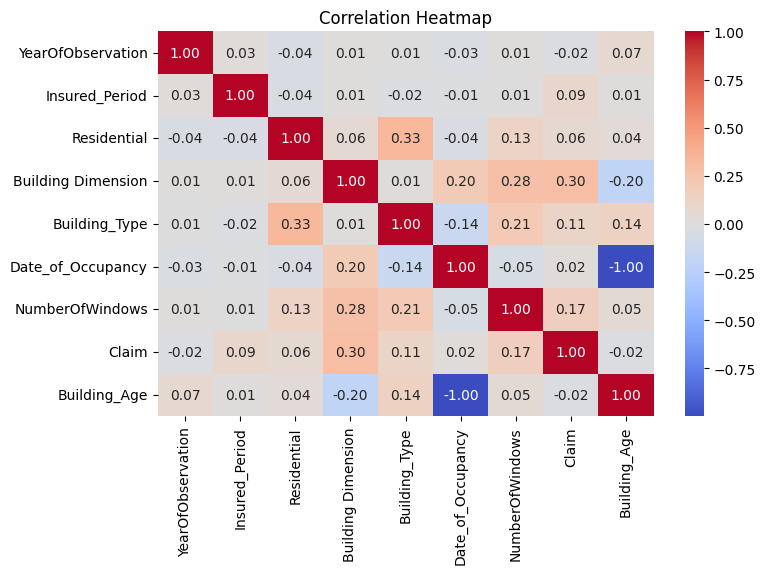

In [13]:
# Correlation Heatmap (only numeric)
plt.figure(figsize=(8, 5))
numeric_df = train_ds.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.savefig('Correlation_heatmap.png')


In [14]:
# Encoding Categorical Variables

# Map binary categories to 0 and 1
le = LabelEncoder()
cat_cols = ['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'Geo_Code']

for col in cat_cols:
    train_ds[col] = le.fit_transform(train_ds[col].astype(str))


**Model Training**

In [15]:
# Split features and target
X = train_ds.drop('Claim', axis=1)
y = train_ds['Claim']

# Split into Training and Validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [16]:
# Initialize Model

model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict probabilities
probs = model.predict_proba(X_val)[:, 1]
preds = model.predict(X_val)


In [17]:
from xgboost import XGBClassifier

In [18]:
# Model 2: XGBoost
xgb_model = XGBClassifier(scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train), random_state=42)
xgb_model.fit(X_train, y_train)
xgb_probs = xgb_model.predict_proba(X_val)[:, 1]
xgb_preds = xgb_model.predict(X_val)


In [19]:
results = {
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [accuracy_score(y_val, preds), accuracy_score(y_val, xgb_preds)],
    'AUC-ROC': [roc_auc_score(y_val, probs), roc_auc_score(y_val, xgb_probs)],
    'F1-Score': [f1_score(y_val, preds), f1_score(y_val, xgb_preds)]
}
results_df = pd.DataFrame(results)
print (results_df)

           Model  Accuracy  AUC-ROC  F1-Score
0  Random Forest  0.776536  0.65943  0.327731
1        XGBoost  0.710196  0.68160  0.424411


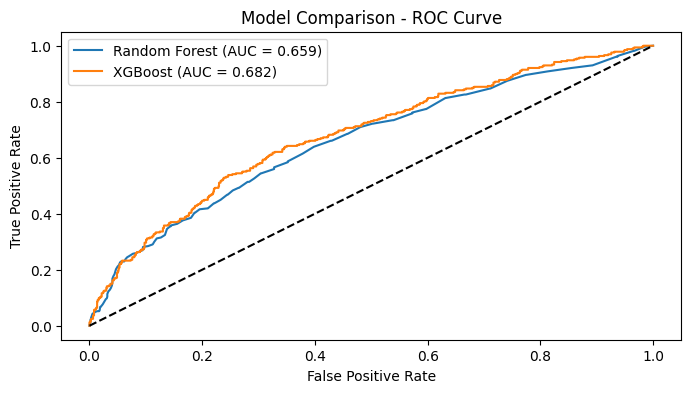

In [20]:
# ROC Curve comparison
plt.figure(figsize=(8, 4))
fpr_rf, tpr_rf, _ = roc_curve(y_val, probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, xgb_probs)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {results_df.iloc[0, 2]:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {results_df.iloc[1, 2]:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Comparison - ROC Curve')
plt.legend()
plt.savefig('model_comparison_roc.png')


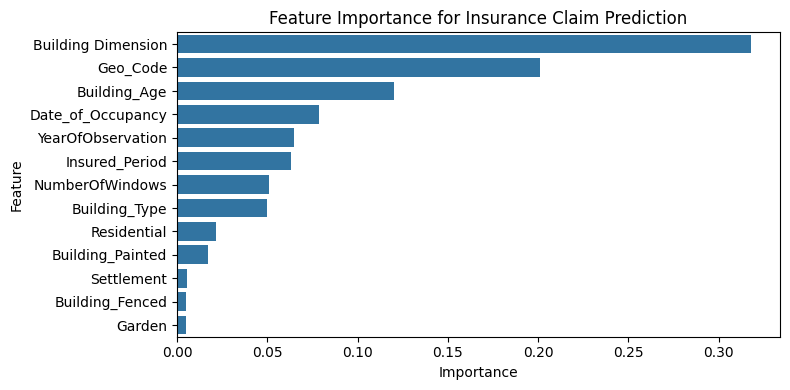

In [21]:
# Importance
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plotting Importance
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance for Insurance Claim Prediction')
plt.tight_layout()


In [22]:
plt.savefig('feature_importance.png')


<Figure size 640x480 with 0 Axes>

In [23]:
print("\nClassification Report:")
print(classification_report(y_val, preds))

print(feature_importance_df)



Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1105
           1       0.52      0.24      0.33       327

    accuracy                           0.78      1432
   macro avg       0.66      0.59      0.60      1432
weighted avg       0.74      0.78      0.74      1432

               Feature  Importance
7   Building Dimension    0.318126
11            Geo_Code    0.201205
12        Building_Age    0.120168
9    Date_of_Occupancy    0.078577
0    YearOfObservation    0.065019
1       Insured_Period    0.063240
10     NumberOfWindows    0.050691
8        Building_Type    0.049538
2          Residential    0.021318
3     Building_Painted    0.016833
6           Settlement    0.005189
4      Building_Fenced    0.005104
5               Garden    0.004992
